## 🛡️ The Global Food Safety Radar: 40 Years of EU RASFF Alerts (1979-2025)
**Author:** Md Shafin Ahamed    
**Domain:** Food Technology | Food Safety Risk Assessment    
**Tools:** Python, Pandas, Seaborn, NLP   

### 📊 Project Overview
The **Rapid Alert System for Food and Feed (RASFF)** is a key tool used by the European Union to ensure the safety of food and feed products. This project analyzes a comprehensive dataset of **100,390** alert notifications spanning 46 years (1979-2025) to uncover global trade risks, contamination trends, and the political economy of food safety inspections.

### 🎯 Objectives
1.  **Harmonize Data:** Merge and clean historical data (1979-2021) with recent raw data (2012-2025).
2.  **Standardize Categories:** Use NLP and mapping techniques to group 29 granular hazard categories into 7 high-level risk groups (e.g., Biological, Chemical).
3.  **Visualize Trends:** Create impactful visualizations to answer key questions about the *What*, *When*, and *Where* of food safety risks.

### 🛠️ Methodology
* **Data Source:** RASFF Portal.
* **Processing:** Python (Pandas, NumPy).
* **Cleaning:**
    * **Temporal:** Fixed a data gap in 2015-2016 by extracting years from Reference IDs.
    * **Geospatial:** Standardized country names (e.g., "Türkiye" -> "Turkey", "China (Hong Kong)" -> "China") to ISO-3 standards.
    * **Taxonomy:** Consolidated 46 product categories into 10 sectors and mapped 29 hazards into 7 macro-groups.

---

### 1. Setup and Data Loading
Importing necessary libraries (Pandas, Seaborn, Matplotlib, Plotly) and loading the raw dataset.

In [66]:
# Import the tools and Data frame 
!pip install squarify matplotlib
import squarify 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.graph_objects as go

df = pd.read_csv(r"D:\data_files\RASFF_Notification_Alert\RASFF_Alert_Notifications_(1979-2025).csv", low_memory = False, encoding = 'utf-8')
pd.set_option('display.max_rows', 200)
#df.columns to see the index

### 2. Data Cleaning & Harmonization
In this section, we perform rigorous data cleaning:
1.  **Date Fix:** Addressing the missing date values in 2015-2016 by recovering the year from the `REFERENCE` column.
2.  **Geospatial Harmonization:** Using Regex and dictionary mapping to standardize country names (e.g., merging "China" and "Hong Kong", fixing "Türkiye" encoding issues).
3.  **Hazard Grouping (NLP):** Mapping 29 specific hazard categories into 7 broad "Risk Groups" (e.g., `mycotoxins` -> `Natural Toxins`).
4.  **Product Categorization:** Grouping 46 product types into 10 major industry sectors (e.g., `crustaceans` -> `Seafood`).

In [67]:
#Year Problem slove 
df['New_Year'] = df['REFERENCE'].astype(str).str.extract(r'^(\d{4})')

# 2. CONVERT TO NUMBER
# Coerce errors so if something extracts weirdly, it becomes NaN instead of crashing
df['New_Year'] = pd.to_numeric(df['New_Year'], errors='coerce')
#print ('Done!') to validate

In [68]:
#DEFINE THE TARGETED FIXES
regex_fixes = {
    # Fix 1: Catch ANY variation of Turkiye (TÃ¼rkiye, Tã¼Rkiye, etc.)
    r'(?i).*T.*rkiye.*': 'Turkey', 
    
    # Fix 2: Catch Hong Kong and merge into China
    r'(?i).*Hong Kong.*': 'China',
    
    # Fix 3: Catch Northern Ireland and merge into UK
    r'(?i).*United Kingdom.*Northern Ireland.*': 'United Kingdom',
    
    # Extra Safety: Catch "The United States" if it's still lurking
    r'(?i)^The United States$': 'United States of America'
}

# 2. APPLY THE FIXES
for pattern, replacement in regex_fixes.items():
    df['Origin'] = df['Origin'].replace(to_replace=pattern, value=replacement, regex=True)

# 3. RE-STANDARDIZE CASE
# Ensure everything is Title Case (e.g., "Turkey" instead of "TURKEY")
df['Origin'] = df['Origin'].str.title()

In [69]:
# 1. STANDARDIZE CASE & STRIP WHITESPACE
# This merges "China" and "CHINA" immediately.
df['Origin'] =  df['Origin'].astype(str).str.upper().str.strip()

# 2. THE MASTER MAPPING DICTIONARY
# This maps your RASFF specific names to Standard Folium Names (United States of America, China, etc.)
country_fix_map = {
    # FIXING THE USA
    "THE UNITED STATES": "United States of America",
    "UNITED STATES": "United States of America",
    "USA": "United States of America",
    
    # FIXING TURKEY (Encoding glitches + Name variations)
    "TÃÂ¼RKIYE": "Turkey", # The glitch you saw
    "TÜRKIYE": "Turkey",
    "TURKEY": "Turkey",
    "Tã¼Rkiye": "Turkey",
    
    # REMOVING "THE" & STANDARDIZING EUROPE
    "THE NETHERLANDS": "Netherlands",
    "THE RUSSIAN FEDERATION": "Russia",
    "RUSSIAN FEDERATION": "Russia",
    "UNITED KINGDOM": "United Kingdom",
    "United Kingdom (Northern Ireland)":"United Kingdom",
    "THE PHILIPPINES": "Philippines",
    "THE DOMINICAN REPUBLIC": "Dominican Republic",
    
    # SPECIFIC RASFF QUIRKS
    "CHINA (HONG KONG)": "China",
    "Hong Kong":"China",# Merging HK into China for the map (Optional)
    "BOSNIA AND HERZEGOVINA": "Bosnia and Herzegovina",
    "VIETNAM": "Vietnam",
    "IRAN": "Iran",
    "SYRIA": "Syria",
    "MOLDOVA": "Moldova",
    "REPUBLIC OF KOREA": "South Korea",
    "SOUTH KOREA": "South Korea"
}

# 3. APPLY THE MAP
# If the name is in our dictionary, replace it. If not, keep it (title cased).
df['Origin_Clean'] =  df['Origin'].replace(country_fix_map)

# 4. TITLE CASE FOR PRETTY MAPS
# "CHINA" -> "China", "UNITED STATES OF AMERICA" -> "United States of America"
df['Origin_Clean'] =  df['Origin_Clean'].str.title() 

# Special correction for "Of" and "And" inside names after title casing
df['Origin_Clean'] =  df['Origin_Clean'].replace({
    'United States Of America': 'United States of America',
    'United Kingdom': 'United Kingdom' # usually fine
})

# 5. VERIFY
# Check the Top 10 again. You should see "China" with huge numbers (merged), and no "The United States".
#print( df['Origin_Clean'].value_counts().head(20))

In [70]:
# Define the mapping dictionary based on Food Safety standards
hazard_group_map = {
    #BIOLOGICAL HAZARDS (Living Organisms) 
    "pathogenic micro-organisms": "Biological",
    "microbial contaminants (other)": "Biological",
    "biological contaminants (other)": "Biological",
    "parasitic infestation": "Biological",
    "TSEs": "Biological", # Transmissible Spongiform Encephalopathies

    #   2. NATURAL TOXINS (Naturally occurring chemicals)  
    "mycotoxins": "Natural Toxins",
    "natural toxins (other)": "Natural Toxins",

    #   3. CHEMICAL HAZARDS (Man-made or Environmental)  
    "pesticide residues": "Chemical",
    "metals": "Chemical", # Heavy metals (Mercury, Lead, etc.)
    "residues of veterinary medicinal products": "Chemical",
    "environmental pollutants": "Chemical",
    "industrial contaminants": "Chemical",
    "chemical contaminants (other)": "Chemical",
    
    #   4. PHYSICAL & PROCESS CONTAMINANTS  
    "foreign bodies": "Physical & Process", # Glass, plastic, insects
    "migration": "Physical & Process", # Chemicals moving from packaging to food
    "packaging defective / incorrect": "Physical & Process",
    "process contaminants": "Physical & Process", # Acrylamide, etc.
    "radiation": "Physical & Process",
    
    #   5. ALLERGENS & ADDITIVES  
    "allergens": "Allergens & Additives",
    "food additives and flavourings": "Allergens & Additives",
    "feed additives": "Allergens & Additives",

    #   6. REGULATORY & QUALITY (Compliance Issues)  
    "composition": "Regulatory & Quality",
    "adulteration / fraud": "Regulatory & Quality",
    "poor or insufficient controls": "Regulatory & Quality",
    "novel food": "Regulatory & Quality",
    "organoleptic aspects": "Regulatory & Quality", # Smell, taste, decay
    "genetically modified food or feed": "Regulatory & Quality",
    "labelling absent/incomplete/incorrect": "Regulatory & Quality",

    #   7. OTHER  
    "not determined / other": "Other"
}

# Apply the mapping to create a NEW column
df['Hazard_Group'] = df['Hazards'].map(hazard_group_map)

# Handle any edge cases (if something didn't match, label it 'Other')
df['Hazard_Group'] = df['Hazard_Group'].fillna('Other')

# Check the results
#print(df[['Hazards', 'Hazard_Group']].sample(10))
#print("\n  Distribution of New Groups  ")
#print(df['Hazard_Group'].value_counts())

In [71]:
product_sector_map = {
    #   1. SEAFOOD  
    "fish and fish products": "Seafood",
    "crustaceans and products thereof": "Seafood",
    "bivalve molluscs and products thereof": "Seafood",
    "cephalopods and products thereof": "Seafood",
    "molluscs and products thereof": "Seafood",
    "gastropods": "Seafood",
    "wild caught fish and products thereof (other than crustaceans and molluscs)": "Seafood",
    "farmed crustaceans and products thereof": "Seafood",
    "wild caught crustaceans and products thereof": "Seafood",
    "farmed fish and products thereof (other than crustaceans and molluscs)": "Seafood",

    #   2. NUTS, SEEDS & SPICES (High Mycotoxin Risk)  
    "nuts, nut products and seeds": "Nuts, Seeds & Spices",
    "herbs and spices": "Nuts, Seeds & Spices",
    "cocoa and cocoa preparations, coffee and tea": "Nuts, Seeds & Spices",

    #   3. FRUITS & VEGETABLES  
    "fruits and vegetables": "Fruits & Vegetables",

    #   4. MEAT & POULTRY  
    "poultry meat and poultry meat products": "Meat & Poultry",
    "meat and meat products (other than poultry)": "Meat & Poultry",
    "animal by-products": "Meat & Poultry",
    "live animals": "Meat & Poultry",

    #   5. CEREALS & CONFECTIONERY  
    "cereals and bakery products": "Cereals & Bakery",
    "confectionery": "Cereals & Bakery",
    "ices and desserts": "Cereals & Bakery",

    #   6. DIETETIC & SUPPLEMENTS (Handling Duplicates here)  
    "dietetic foods, food supplements, fortified foods": "Dietetic & Supplements",
    "dietetic foods, food supplements and fortified foods": "Dietetic & Supplements", # Note the 'and' vs ',' difference

    #   7. DAIRY, EGGS & HONEY  
    "milk and milk products": "Dairy, Eggs & Honey",
    "eggs and egg products": "Dairy, Eggs & Honey",
    "honey and royal jelly": "Dairy, Eggs & Honey",

    #   8. ANIMAL FEED (Non-Human)  
    "feed materials": "Animal Feed",
    "pet food": "Animal Feed",
    "animal nutrition": "Animal Feed",
    "compound feeds": "Animal Feed",
    "feed for food-producing animals": "Animal Feed",
    "feed additives": "Animal Feed",
    "feed premixtures": "Animal Feed",

    #   9. FOOD CONTACT MATERIALS  
    "food contact materials": "Food Contact Materials",

    #   10. PREPARED, BEVERAGES & OTHERS  
    "other food product / mixed": "Prepared & Beverages",
    "prepared dishes and snacks": "Prepared & Beverages",
    "soups, broths, sauces and condiments": "Prepared & Beverages",
    "fats and oils": "Prepared & Beverages",
    "non-alcoholic beverages": "Prepared & Beverages",
    "alcoholic beverages": "Prepared & Beverages",
    "wine": "Prepared & Beverages",
    "water for human consumption (other)": "Prepared & Beverages",
    "natural mineral water": "Prepared & Beverages",
    "natural mineral waters": "Prepared & Beverages", # Duplicate handling
    "food additives and flavourings": "Prepared & Beverages",
    "plant protection products": "Prepared & Beverages"
}

# Apply the mapping
df['Product_Sector'] = df['Product_category'].map(product_sector_map)

# Catch any typos or missing items
df['Product_Sector'] = df['Product_Sector'].fillna('Other')

# Check distribution
#print(df['Product_Sector'].value_counts())

### 3. The "Toxic Matrix": Hazard Intensity Analysis
**Question:** *Which product sectors are most prone to specific types of contamination?*

This heatmap visualizes the correlation between **Product Sectors** and **Hazard Groups**. It highlights "Red Zones" where specific food types face systemic issues (e.g., Nuts/Seeds and Natural Toxins).

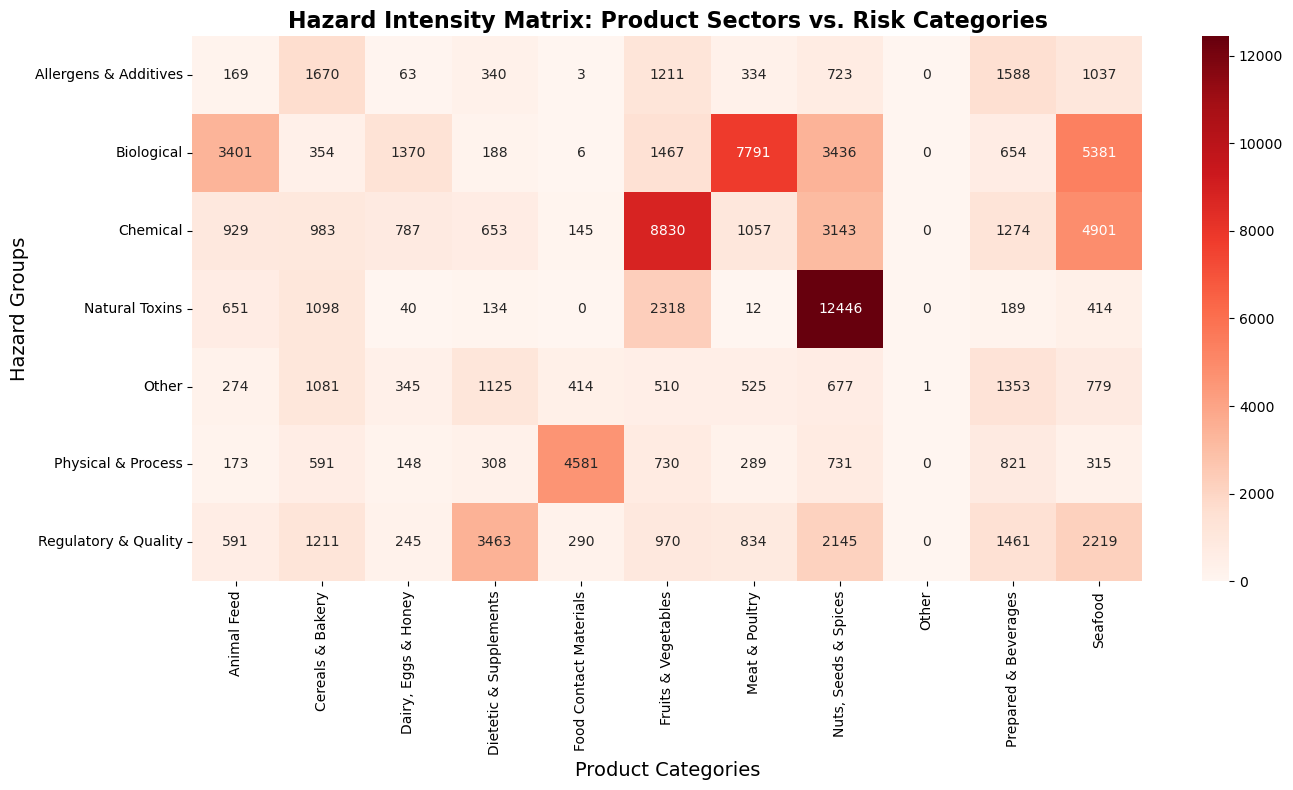

In [102]:
#Hotmap: The Toxic Matrix 
all_hazards = df['Hazard_Group'].value_counts().index
all_products = df['Product_Sector'].value_counts().index

subset = df[df['Hazard_Group'].isin(all_hazards) & 
            df['Product_Sector'].isin(all_products)]

pivot_table = pd.crosstab(subset['Hazard_Group'], subset['Product_Sector'])

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='Reds',)
plt.title('Hazard Intensity Matrix: Product Sectors vs. Risk Categories', fontsize=16, fontweight='bold')
plt.xlabel('Product Categories', fontsize=14)
plt.ylabel('Hazard Groups', fontsize=14)
plt.savefig("Food_Products_vs_Hazard_Groups.png", bbox_inches='tight', dpi = 300)
plt.tight_layout()
plt.show()

### 4. The "Global Watchdog": Top Countries of Origin
**Question:** *Who are the biggest sources of food safety alerts?*

This horizontal bar chart displays the Top 20 countries of origin for alerts. By cleaning the geospatial data, we reveal the true scale of alerts from major trading partners like China, Turkey, and India.

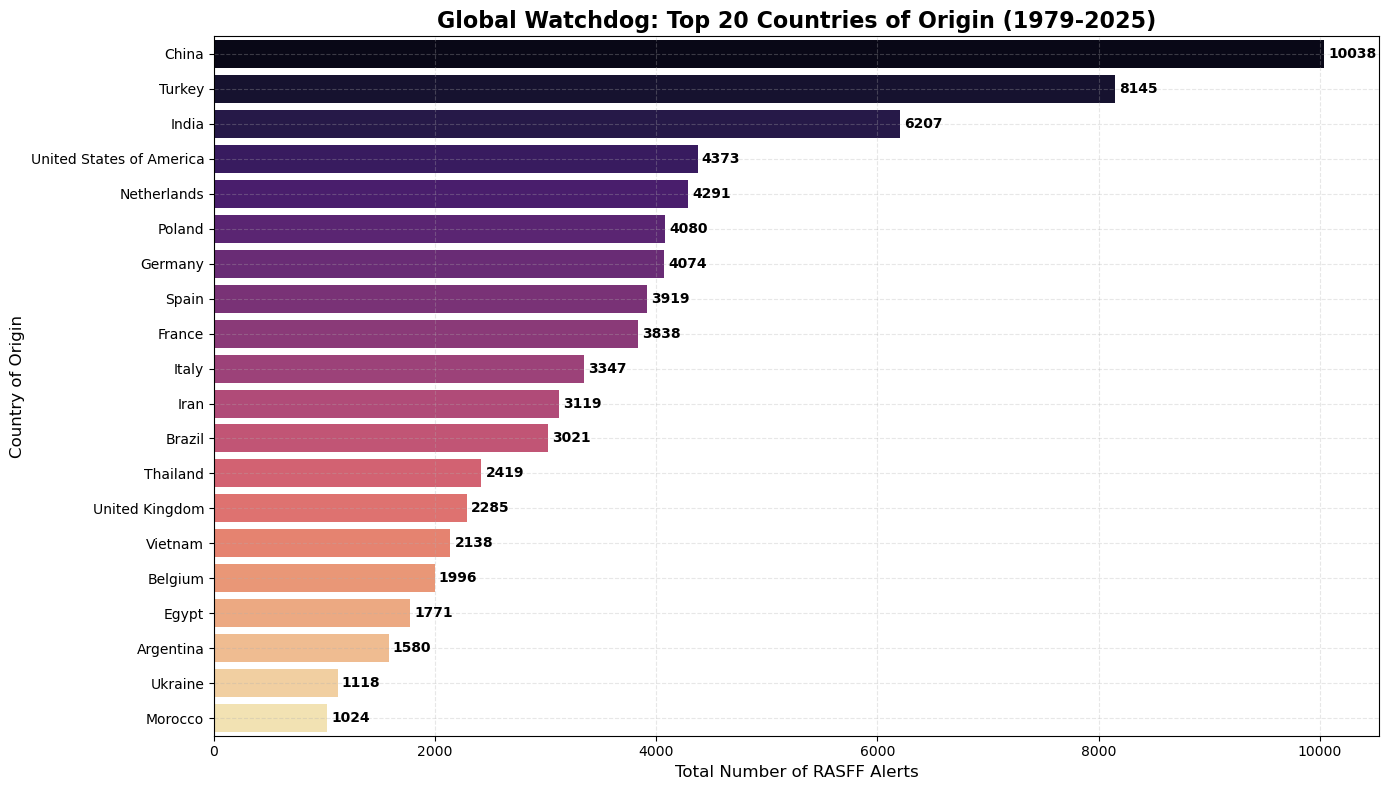

In [103]:
#Horizontal Bar Chard, Most Alerted Origins 

top20_origins = df['Origin_Clean'].value_counts().head(20)

plt.figure(figsize=(14,8))

ax = sns.barplot(
    x=top20_origins.values,
    y=top20_origins.index,
    hue = top20_origins.index,
    legend = False,
    palette = 'magma'
)

for container in ax.containers :
    ax.bar_label(container, padding = 3, weight = 600)

plt.title('Global Watchdog: Top 20 Countries of Origin (1979-2025)', fontsize=16, fontweight='bold')
plt.xlabel('Total Number of RASFF Alerts', fontsize=12)
plt.ylabel('Country of Origin', fontsize=12)
plt.grid( True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('RASFF_20_Most_Alerted_Origins.png', dpi=300)
plt.show()

### 5. Longitudinal Trend: The Evolution of Risk (2000-2025)
**Question:** *How have food safety risks changed over the last 25 years?*

This multi-line chart tracks the annual volume of alerts for each Hazard Group. It reveals historical shifts, such as the rise of "Natural Toxins" in the early 2000s and the surge in "Other" hazards (likely Ethylene Oxide) in 2020-2021.

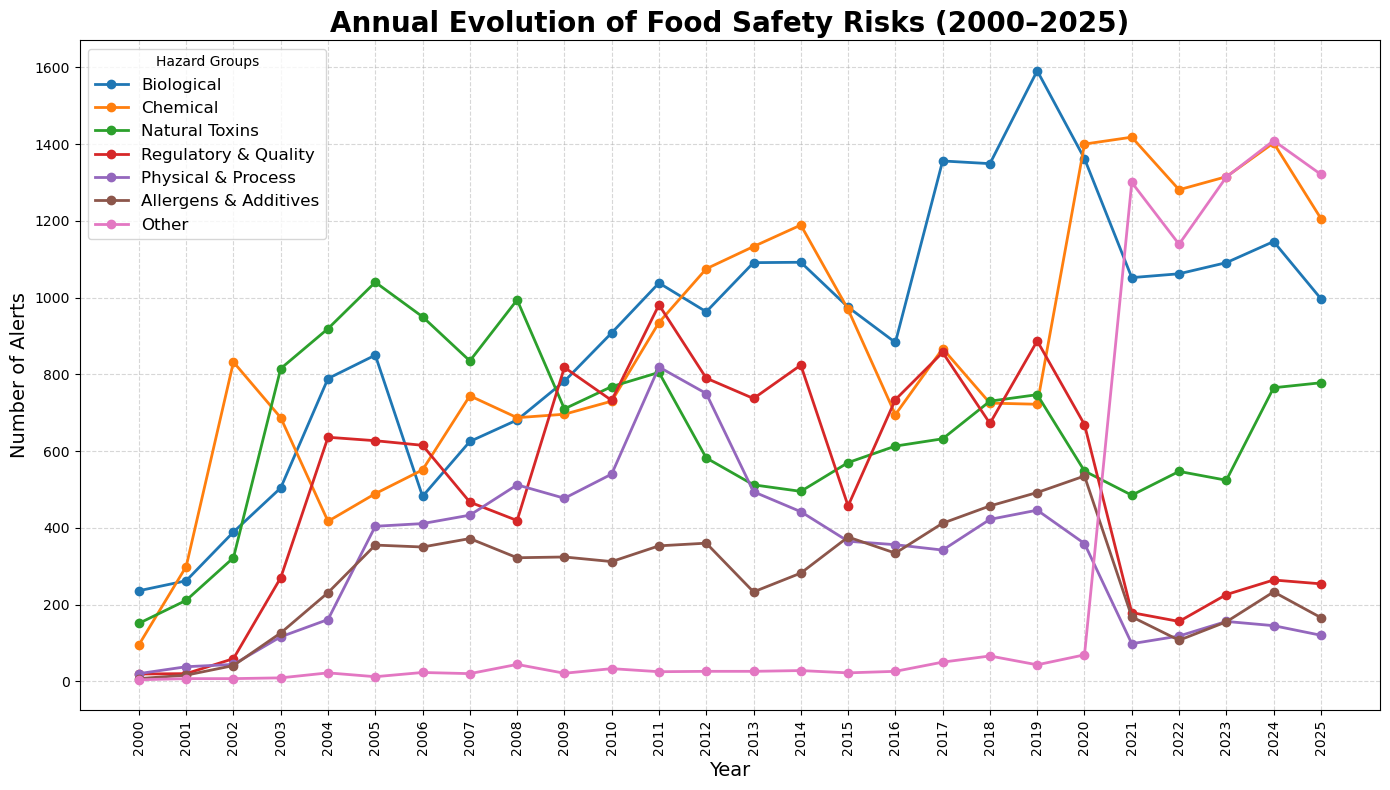

In [104]:
#Evolution of Risk, Line Chart 
df_year = df[(df['New_Year'] >= 2000) & (df['New_Year'] <= 2025)].copy()
df_Hazard_Group = df['Hazard_Group'].value_counts().index

#Plot
plt.figure(figsize=(14, 8))

#Loop through top categories to plot lines
for cat in df_Hazard_Group:
    cat_data = df_year[df_year['Hazard_Group'] == cat]['New_Year'].value_counts().sort_index()
    cat_data = cat_data.reindex(range(2000, 2026), fill_value=0)
    plt.plot(cat_data.index, cat_data.values, marker='o', label=cat, linewidth=2)

#Formatting
plt.title('Annual Evolution of Food Safety Risks (2000–2025)', fontsize=20, weight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Alerts', fontsize=14)
plt.xticks(range(2000, 2026), rotation = 90)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Hazard Groups", fontsize=12)
#Display
plt.tight_layout()
plt.savefig('Annual_Evolution_of_Risk_(2000-2025).png', dpi=300)
plt.show()

### 6. The "Gatekeepers": Notifier vs. Origin Analysis
**Question:** *Who is policing the borders, and who are they targeting?*

This heatmap exposes the political economy of food safety. It shows the relationship between the **Notifying Country** (the detector) and the **Origin Country** (the source). Strong correlations (e.g., Italy vs. Turkey, UK vs. India) suggest specific trade routes and inspection priorities.

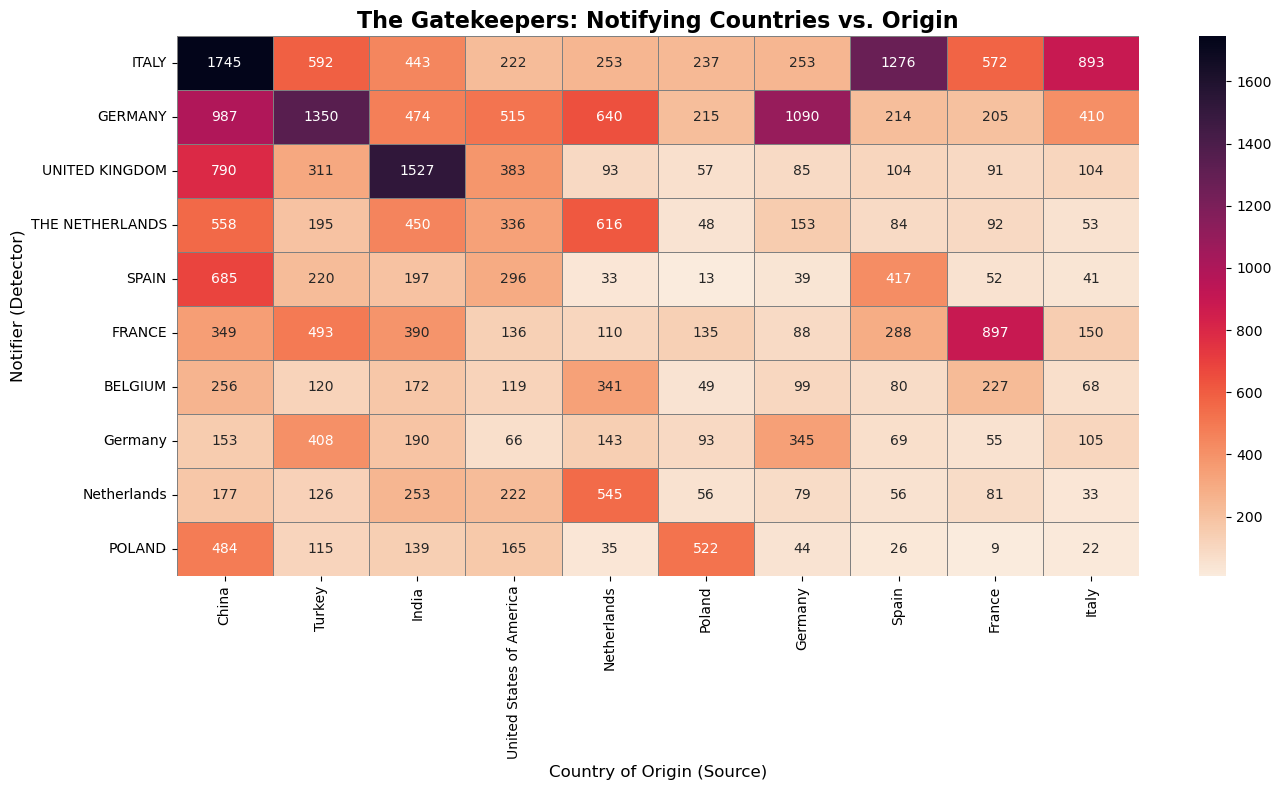

In [101]:
top10_notifier = df['Notifier'].value_counts().head(10).index
top10_origin = df['Origin_Clean'].value_counts().head(10).index

# 2. Create Subset
subset = df[
    df['Notifier'].isin(top10_notifier) & 
    df['Origin_Clean'].isin(top10_origin)
]

# 3. Create Crosstab (Pandas will auto-sort this A-Z)
pivot_table = pd.crosstab(subset['Notifier'], subset['Origin_Clean'])

# 4. THE FIX: Reindex using your sorted lists
# This forces the rows and columns to follow the order of importance, not the alphabet.
pivot_table = pivot_table.reindex(index=top10_notifier, columns=top10_origin)

# 5. Plot
plt.figure(figsize=(14, 8))
sns.heatmap(
    pivot_table, 
    annot=True, 
    fmt='d', 
    cmap='rocket_r', 
    linewidths=0.5, # Adds grid lines for readability
    linecolor='gray'
)

plt.title('The Gatekeepers: Notifying Countries vs. Origin', fontsize=16, fontweight='bold')
plt.xlabel('Country of Origin (Source)', fontsize=12)
plt.ylabel('Notifier (Detector)', fontsize=12)

plt.savefig("Notifier_vs_Origin_Sorted.png", bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()

### 7. Global Risk Flow (Sankey Diagram)
**Question:** *How do contaminants flow from global origins to specific hazards?*

This interactive Sankey diagram visualizes the flow of risks from **Origin Countries** -> **Product Sectors** -> **Hazard Groups**. It provides a holistic view of the global food safety landscape.

In [ ]:
#This File is available in both PNG and HTML for 
# 1. PREPARE DATA (FILTERING IS CRUCIAL)
# A Sankey with 100 countries is unreadable. We take the "Big Players".
# Top 10 Origins -> Top 10 Products -> Top 7 Hazard Groups

top_n_origins = 10
top_n_products = 10

# Get the lists of top items
top_origins = df['Origin_Clean'].value_counts().head(top_n_origins).index.tolist()
top_products = df['Product_Sector'].value_counts().head(top_n_products).index.tolist()

# Filter the dataframe to only include these flows
df_sankey = df[
    (df['Origin_Clean'].isin(top_origins)) & 
    (df['Product_Sector'].isin(top_products))
]

# 2. CREATE SOURCE -> TARGET LINKS

# Step A: Origin -> Product
flow_1 = df_sankey.groupby(['Origin_Clean', 'Product_Sector']).size().reset_index(name='Count')
flow_1.columns = ['Source', 'Target', 'Value']

# Step B: Product -> Hazard Group
flow_2 = df_sankey.groupby(['Product_Sector', 'Hazard_Group']).size().reset_index(name='Count')
flow_2.columns = ['Source', 'Target', 'Value']

# Combine flows
links = pd.concat([flow_1, flow_2], axis=0)

# 3. MAP LABELS TO NUMBERS (Sankey needs ID numbers, not names)
# Get all unique labels
all_labels = list(pd.unique(links[['Source', 'Target']].values.ravel('K')))

# Create a mapping dictionary {Name: ID}
label_map = {name: i for i, name in enumerate(all_labels)}

# Transform data to IDs
links['Source_ID'] = links['Source'].map(label_map)
links['Target_ID'] = links['Target'].map(label_map)

# 4. DEFINE COLORS (Optional aesthetics)
# We can make distinct colors for Hazards to make them pop
color_map = {
    'Biological': '#e74c3c', # Red
    'Chemical': '#f39c12',   # Orange
    'Natural Toxins': '#8e44ad', # Purple
    'Physical & Process': '#3498db', # Blue
    'China': '#2c3e50', # Dark Grey
    'Turkey': '#2c3e50',
    'India': '#2c3e50'
}
# Assign default grey if not in map
node_colors = [color_map.get(label, '#95a5a6') for label in all_labels]

# 5. PLOT
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_labels,
        color=node_colors
    ),
    link=dict(
        source=links['Source_ID'],
        target=links['Target_ID'],
        value=links['Value'],
        # Color links based on source (optional gradient effect)
        # color = '#d3d3d3' 
    )
)])

fig.update_layout(
    title_text="Global Food Safety Risk Flow (Origin -> Product -> Hazard)",
    font_size=12,
    height=800
)

# Save as HTML (Interactive)
fig.write_html("RASFF_Sankey.html")
#print("Sankey Diagram saved as 'RASFF_Sankey.html'. Open it to explore the flow!")

## 🏁 Conclusion
This analysis demonstrates that EU food safety alerts are not random but follow distinct **geospatial, temporal, and sectoral patterns**.

**Key Findings:**
* **China** is the undisputed leader in alerts, followed by **Turkey** and **India**.
* **Nuts, Seeds & Spices** are the highest-risk category, primarily due to **Mycotoxins**.
* **Gatekeeper Bias:** Inspection intensity varies significantly by country, with nations like **Germany**, **Italy**, and the **UK** acting as the primary detectors for specific trade partners.
* **Data Integrity:** The rigorous cleaning process (recovering 5,800+ lost records) was crucial for accurate historical trend analysis.